In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn.modules.conv import Conv2d
from torchvision import transforms

/Users/ishaan/miniconda3/envs/VisualSearch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ishaan/miniconda3/envs/VisualSearch/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/ishaan/miniconda3/envs/VisualSearch/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <8E6D6BF5-9658-33B9-9D3C-DF587B2F99E7> /Users/ishaan/miniconda3/envs/VisualSearch/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
class IVSN(nn.Module):
  def __init__(self, model):
      super(IVSN, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      return x

ConvSize, NumTemplates, Mylayer = 1, 512, 31
TotalTrials = 68
MMconv = Conv2d(NumTemplates, 1, kernel_size = (ConvSize, ConvSize), stride = (1, 1), padding = (1, 1))
# 512 input channels, 1 output channel, 1x1 kernel, stride 1, padding 1

In [4]:
from torchvision.models import VGG16_Weights

model_vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights=VGG16_Weights.DEFAULT)
model_ivsn = IVSN(model_vgg)
model_ivsn

Using cache found in /Users/ishaan/.cache/torch/hub/pytorch_vision_v0.10.0


IVSN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [5]:
import waldoDataset

input_images = waldoDataset.WaldoDataset('data/waldo/gt', 'data/waldo/stimuli', 'data/waldo/target', normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])

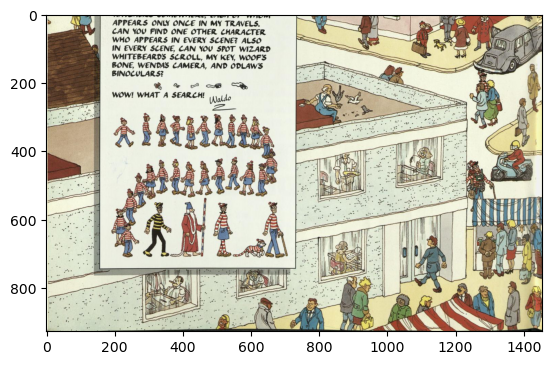

(1240, 424, 1279, 463)


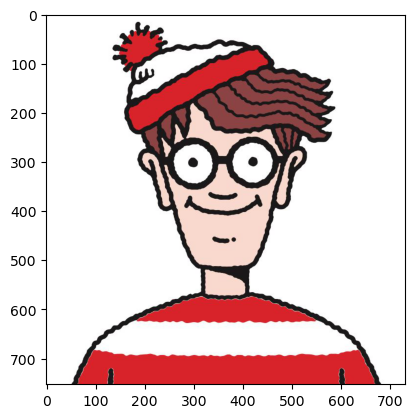

In [6]:
import matplotlib.pyplot as plt

plt.imshow(input_images[0][0].permute(1, 2, 0))
plt.show()
plt.imshow(input_images[0][1].permute(1, 2, 0))
print(input_images[0][2])

max value in attentionMap 1.0
searching at (136, 828)
max value in attentionMap 0.996124
searching at (136, 878)
max value in attentionMap 0.992708
searching at (227, 829)
max value in attentionMap 0.98997116
searching at (227, 879)
max value in attentionMap 0.9856185
searching at (277, 828)
max value in attentionMap 0.97866094
searching at (85, 828)
max value in attentionMap 0.9769957
searching at (277, 878)
max value in attentionMap 0.9756666
searching at (85, 878)
max value in attentionMap 0.96364456
searching at (327, 828)
max value in attentionMap 0.96246237
searching at (136, 777)
max value in attentionMap 0.9497517
searching at (226, 778)
max value in attentionMap 0.94961965
searching at (327, 878)
max value in attentionMap 0.94675195
searching at (135, 726)
max value in attentionMap 0.9447266
searching at (276, 777)
max value in attentionMap 0.94383466
searching at (85, 777)
max value in attentionMap 0.9406947
searching at (34, 828)
max value in attentionMap 0.938506
searching 

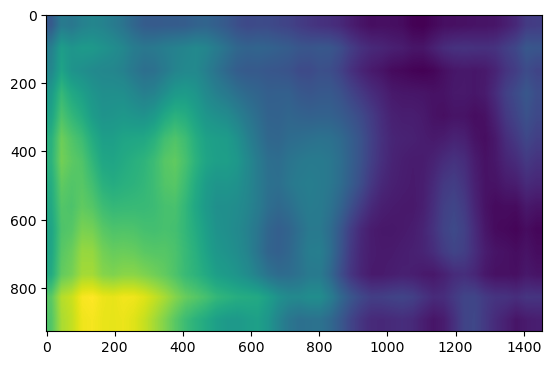

In [8]:
import torch
from tqdm import trange
from utils import waldoSearchProcesswithPath

num_pics = len(input_images) #240 images
IVSN_attention_map, scanpath = {}, {}
IVSN_res = list()

with torch.no_grad():
    for id in range(1):
        stimuli_img, target_img, bbox = input_images[id]
        #Need 3 channels:
        if stimuli_img.shape[0] == 1:
            stimuli_img = torch.cat((stimuli_img, stimuli_img, stimuli_img), 0)
        if target_img.shape[0] == 1:
            target_img = torch.cat((target_img, target_img, target_img), 0)
        
        
        stimuli_batch = stimuli_img.unsqueeze(0)
        target_batch = target_img.unsqueeze(0) 
        
        # Get the output from the model after going through all 30 layers
        stimuli_output = model_ivsn(stimuli_batch)
        target_output = model_ivsn(target_batch)
        
        # Update MMconv weights with target output
        MMconv.weight = torch.nn.Parameter(target_output)
        
        # Get the attention map by applying MMconv to stimuli_output
        attention_IVSN = MMconv(stimuli_output) 
        attention_IVSN = attention_IVSN.squeeze(0)
                
        # Normalize the attention map
        mask_IVSN = transforms.Resize((stimuli_img.shape[1], stimuli_img.shape[2]))(attention_IVSN)
        mask_IVSN = mask_IVSN.squeeze(0)
        mask_IVSN = torch.divide(mask_IVSN, mask_IVSN.max())
                        
        IVSN_attention_map[id] = mask_IVSN.clone().detach() #create deepcopy
        
        IVSN_num, path = waldoSearchProcesswithPath(mask_IVSN, bbox)
        scanpath[id] = path
        IVSN_res.append(IVSN_num)

print(IVSN_res)

plt.imshow(IVSN_attention_map[0])
